In [1]:
import numpy as np
import pandas as pd
import glob
import random

# image
from PIL import Image

# visu
import matplotlib.pyplot as plt

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

In [2]:
BATCH_SIZE = 64
IMG_WIDTH  = int(224/4)
IMG_HEIGHT = int(224/4)
MAX_EPOCHS = 1000

VGG_BATCH_SIZE = 16
VGG_IMG_WIDTH  = 224
VGG_IMG_HEIGHT = 224
VGG_MAX_EPOCHS = 100

In [3]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, zoom_range=(0.8, 1.2))

train_generator = datagen.flow_from_directory('./input/train',
                                                      batch_size=BATCH_SIZE,
                                                      target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                      class_mode='categorical')

validation_generator = datagen.flow_from_directory('./input/valid',
                                                           batch_size=BATCH_SIZE,
                                                           target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                           class_mode='categorical')

test_generator = datagen.flow_from_directory('./input/test',
                                                           batch_size=BATCH_SIZE,
                                                           target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                           class_mode='categorical')

Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


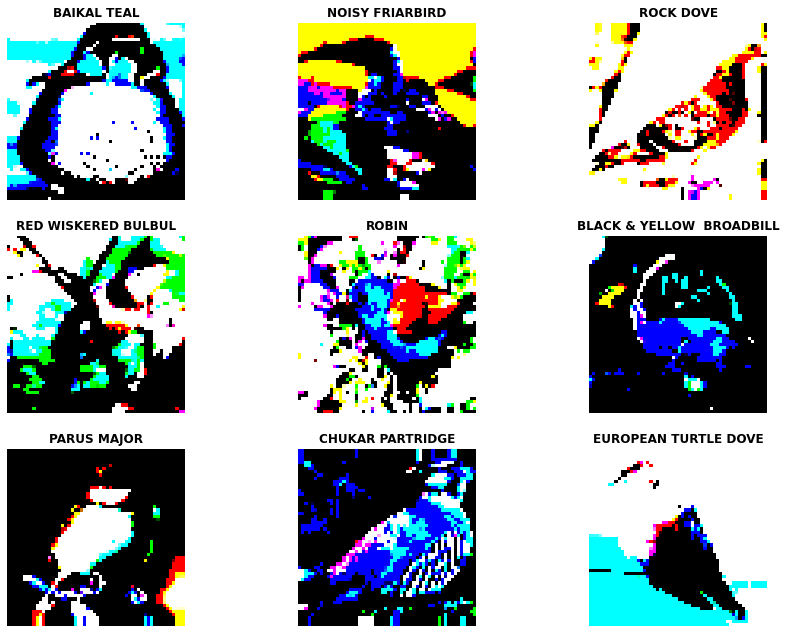

In [4]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for row in range(0, 3):
    for col in range(0, 3):
        image, label = train_generator.next()
        label_id = list(label[0]).index(1)
        label_str = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(label_id)]
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off');
        ax.set_title(label_str, fontdict={"fontweight": 700})
        ax.imshow(image[0]);

In [5]:
def makeMyModel(name):
    model = Sequential(name=name)
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(400, activation='softmax'))

    return model

In [6]:
model = makeMyModel("BirdsBase")
model.summary()

Model: "BirdsBase"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0 

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics="accuracy")

In [8]:
callback = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.5, verbose=1)]
#
history_baseline = model.fit(train_generator,
                                      batch_size=BATCH_SIZE,
                                      epochs=MAX_EPOCHS,
                                      validation_data=validation_generator,
                                      callbacks=callback)

model.save(f"{model.name}.h5")


Epoch 1/1000
913/913 [==============================] - 75s 79ms/step - loss: 5.6159 - accuracy: 0.0184 - val_loss: 4.6981 - val_accuracy: 0.0665
Epoch 2/1000
913/913 [==============================] - 57s 62ms/step - loss: 4.4843 - accuracy: 0.0895 - val_loss: 3.7819 - val_accuracy: 0.1735
Epoch 3/1000
913/913 [==============================] - 57s 62ms/step - loss: 3.9471 - accuracy: 0.1535 - val_loss: 3.2369 - val_accuracy: 0.2540
Epoch 4/1000
913/913 [==============================] - 61s 66ms/step - loss: 3.6238 - accuracy: 0.2051 - val_loss: 3.0290 - val_accuracy: 0.2945
Epoch 5/1000
913/913 [==============================] - 59s 64ms/step - loss: 3.3953 - accuracy: 0.2432 - val_loss: 2.7209 - val_accuracy: 0.3645
Epoch 6/1000
913/913 [==============================] - 55s 60ms/step - loss: 3.2156 - accuracy: 0.2739 - val_loss: 2.6248 - val_accuracy: 0.3840
Epoch 7/1000
913/913 [==============================] - 55s 60ms/step - loss: 3.0648 - accuracy: 0.3045 - val_loss: 2.5909 -

In [9]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

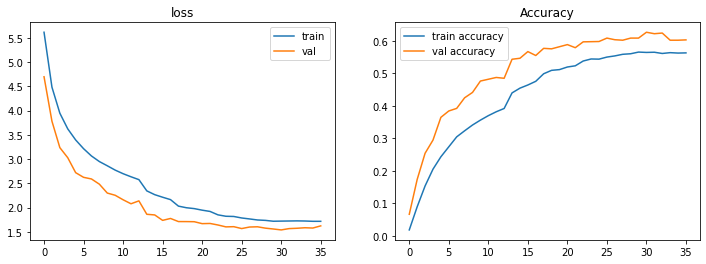

In [10]:
plot_history(history_baseline, title='', axs=None, exp_name="");


In [11]:
model.evaluate(test_generator, verbose=0)

[1.4158686399459839, 0.6474999785423279]

In [12]:
model_VGG = VGG16(include_top=False, weights='imagenet', input_shape=(VGG_IMG_WIDTH, VGG_IMG_HEIGHT, 3))
model_VGG.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
model_VGG.trainable = False
model_VGG.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
flattening_layer = layers.Flatten()
dropout = layers.Dropout(rate=0.4)
norm = layers.BatchNormalization()
last_layer = layers.Dense(400, activation='softmax')

model_VGG = Sequential([model_VGG, flattening_layer, dropout, norm, last_layer])

model_VGG.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense_3 (Dense)              (None, 400)               10035600  
Total params: 24,850,640
Trainable params: 10,085,776
Non-trainable params: 14,764,864
_________________________________________________________________


In [15]:
model_VGG.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics="accuracy")

In [16]:
train_generator = datagen.flow_from_directory('./input/train',
                                                      batch_size=VGG_BATCH_SIZE,
                                                      target_size=(VGG_IMG_WIDTH, VGG_IMG_HEIGHT),
                                                      class_mode='categorical')

validation_generator = datagen.flow_from_directory('./input/valid',
                                                           batch_size=VGG_BATCH_SIZE,
                                                           target_size=(VGG_IMG_WIDTH, VGG_IMG_HEIGHT),
                                                           class_mode='categorical')

test_generator = datagen.flow_from_directory('./input/test',
                                                           batch_size=VGG_BATCH_SIZE,
                                                           target_size=(VGG_IMG_WIDTH, VGG_IMG_HEIGHT),
                                                           class_mode='categorical')

Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.


In [17]:
callback = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.5, verbose=1)]

history_VGG = model_VGG.fit(train_generator,
                            epochs=VGG_MAX_EPOCHS,
                            validation_data=validation_generator,
                            callbacks=callback)

Epoch 1/100
3650/3650 [==============================] - 382s 104ms/step - loss: 3.8497 - accuracy: 0.5489 - val_loss: 1.5845 - val_accuracy: 0.8395
Epoch 2/100
3650/3650 [==============================] - 375s 103ms/step - loss: 1.3333 - accuracy: 0.8374 - val_loss: 1.7250 - val_accuracy: 0.8585

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 3/100
3650/3650 [==============================] - 373s 102ms/step - loss: 0.6939 - accuracy: 0.9066 - val_loss: 1.2857 - val_accuracy: 0.8835
Epoch 4/100
3650/3650 [==============================] - 377s 103ms/step - loss: 0.4615 - accuracy: 0.9334 - val_loss: 1.2913 - val_accuracy: 0.8825

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5/100
3650/3650 [==============================] - 377s 103ms/step - loss: 0.3130 - accuracy: 0.9523 - val_loss: 1.2799 - val_accuracy: 0.8905
Epoch 6/100
3650/3650 [==============================] - 374s 102ms/step - loss: 0.2290 - acc

In [18]:
model_VGG.save("model_VGG.h5")